In [1]:
from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from xgboost.sklearn import XGBRegressor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap

import lime
import lime.lime_tabular

def Load_Model(returnvalue):
    df = pd.read_csv(r'C:\Users\celin\Documents\VSC Documents\Thesis\data\analysis\03_new_model_training\03_new_model_training\new_model_training_dataset.csv')

    df = df[(df[["wind_speed"]] != 0).any(axis=1)]
    df = df.drop(columns=["grid_point_id", "typhoon_year"])

    df = df.fillna(0) 

    features = [
        "wind_speed",
        "track_distance",
        "total_houses",
        "rainfall_max_6h",
        "rainfall_max_24h",
        "rwi",
        "mean_slope",
        "std_slope",
        "mean_tri",
        "std_tri",
        "mean_elev",
        "coast_length",
        "with_coast",
        "urban",
        "rural",
        "water",
        "total_pop",
        "percent_houses_damaged_5years",
    ]

    # Split X and y from dataframe features
    X = df[features]
    y = df["percent_houses_damaged"]

    scaler = preprocessing.StandardScaler().fit(X)
    X_scaled = scaler.transform(X)

    bins2 = [0, 0.00009, 1, 10, 50, 101]
    samples_per_bin2, binsP2 = np.histogram(df["percent_houses_damaged"], bins=bins2)
    bin_index2 = np.digitize(df["percent_houses_damaged"], bins=binsP2)
    y_input_strat = bin_index2
    y_input_strat[997] = 5

    unique_values, value_counts = np.unique(y_input_strat, return_counts=True)

    # Split dataset into training set and test set
    y_input_strat = y_input_strat

    # added random state
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, df["percent_houses_damaged"], stratify=y_input_strat, test_size=0.2, random_state = 10
    )

    df_red = df[features + ["percent_houses_damaged"]]



    # print(df_red.shape)

    if returnvalue == "df":
        return df_red

    data_train, data_test = train_test_split(df_red, test_size=0.2, random_state = 10)
    # print(data_train.shape)

    # XGBoost Reduced Overfitting
    xgb = XGBRegressor(
        base_score=0.5,
        booster="gbtree",
        colsample_bylevel=0.8,
        colsample_bynode=0.8,
        colsample_bytree=0.8,
        gamma=3,
        eta=0.01,
        importance_type="gain",
        learning_rate=0.1,
        max_delta_step=0,
        max_depth=4,
        min_child_weight=1,
        missing=1,
        n_estimators=100,
        early_stopping_rounds=10,
        n_jobs=1,
        nthread=None,
        objective="reg:squarederror",
        reg_alpha=0,
        reg_lambda=1,
        scale_pos_weight=1,
        seed=None,
        silent=None,
        subsample=0.8,
        verbosity=1,
        eval_metric=["rmse", "logloss"],
        random_state=0,
    )

    eval_set = [(X_train, y_train)]
    xgb_model = xgb.fit(X_train, y_train, eval_set=eval_set, verbose=False)

    if returnvalue == "xgb_model":
        return xgb_model

    if returnvalue == "X_train":
        return X_train
    
    if returnvalue == "X_test":
        return X_test
    
    if returnvalue == "y_train":
        return y_train
    
    if returnvalue == "y_test":
        return y_test
    
    if returnvalue == "features":
        return features
    



In [2]:
from model_function import Load_Model

In [6]:
from model_function import Load_Model

features = Load_Model("features")
X_train = Load_Model("X_train")
xgb_model = Load_Model("xgb_model")
X_test = Load_Model("X_test")
df = Load_Model("df")


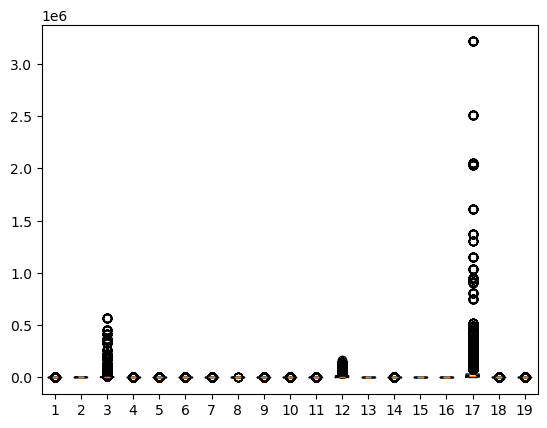

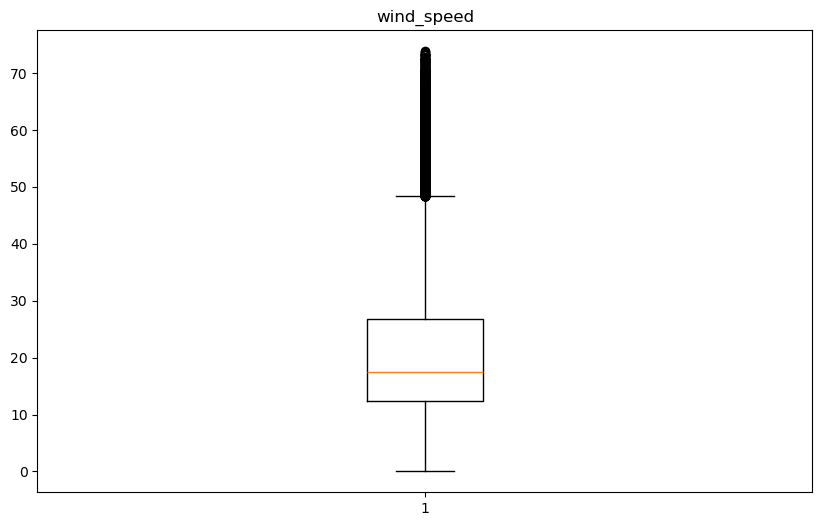

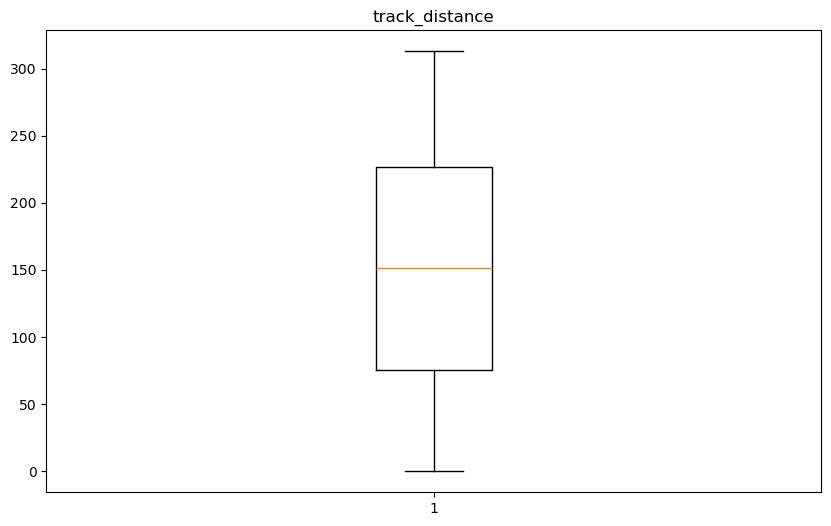

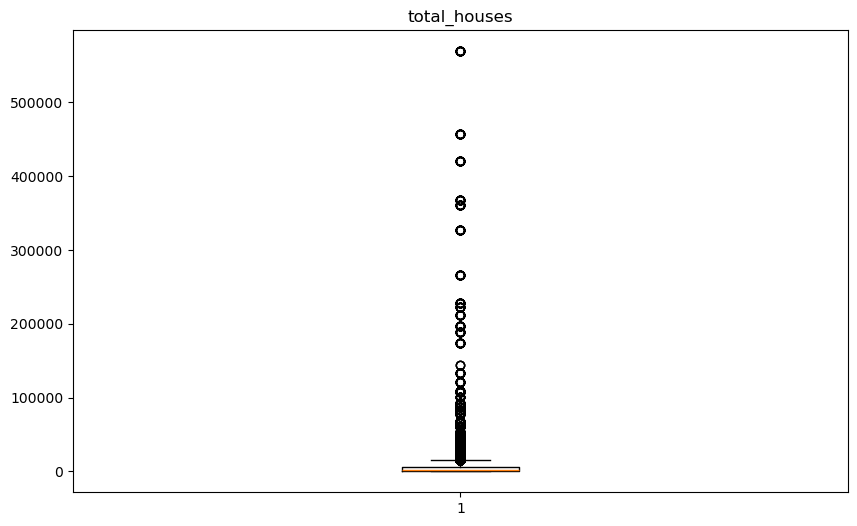

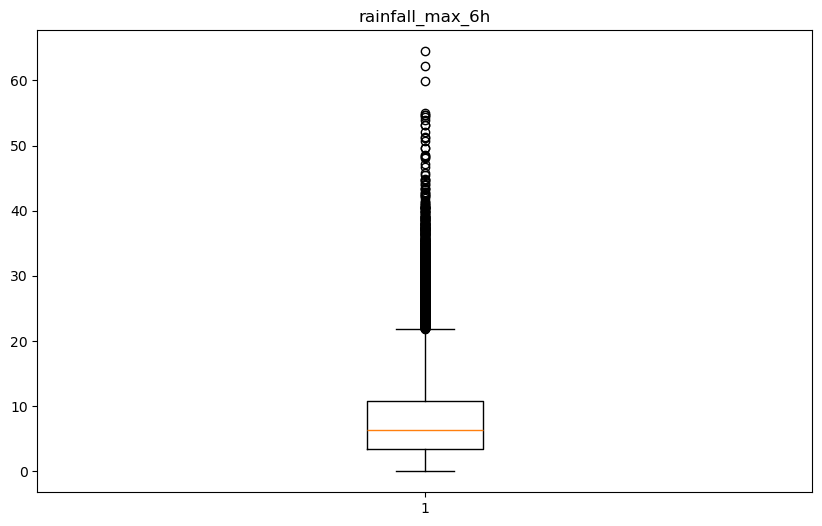

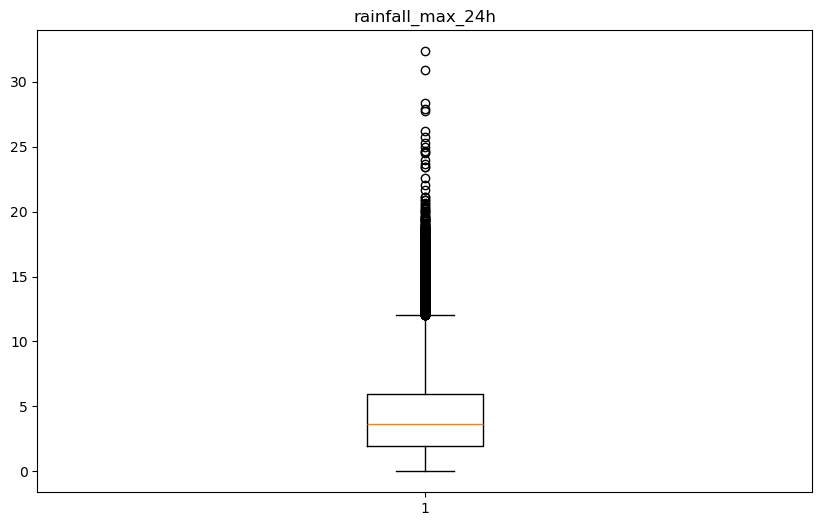

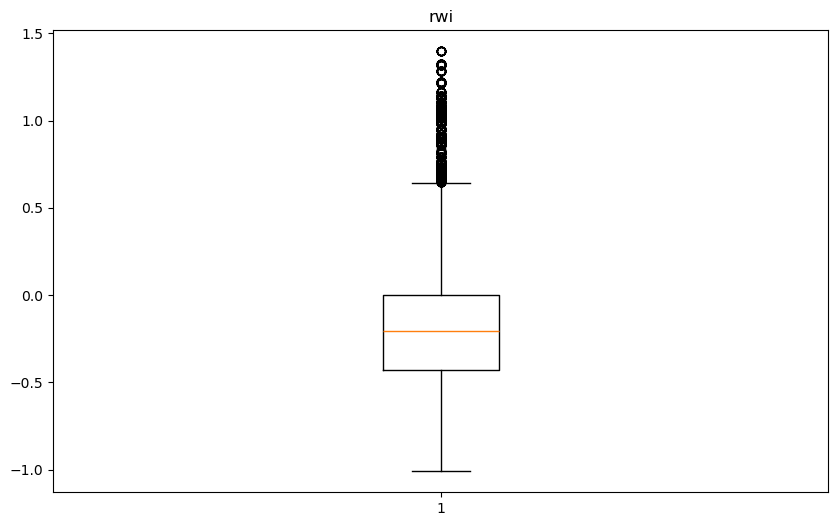

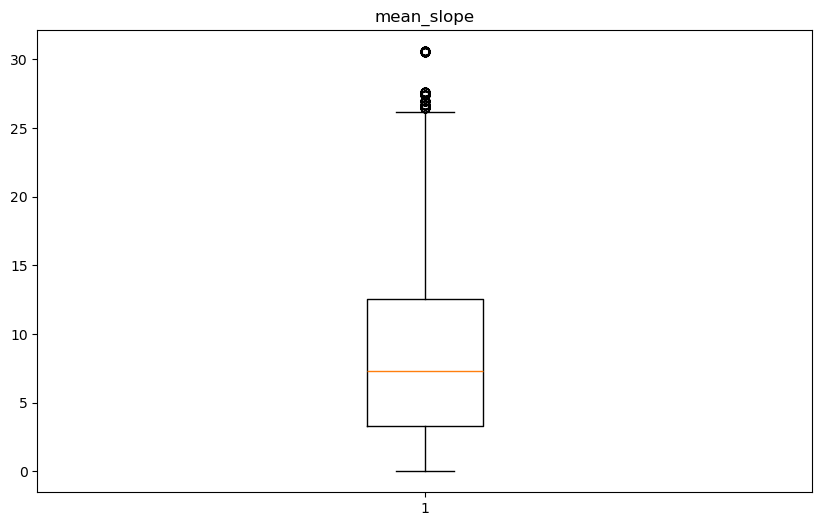

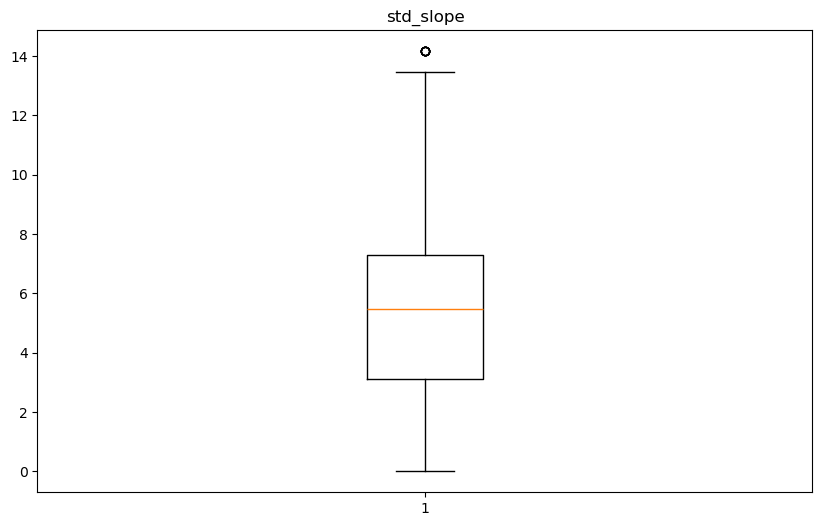

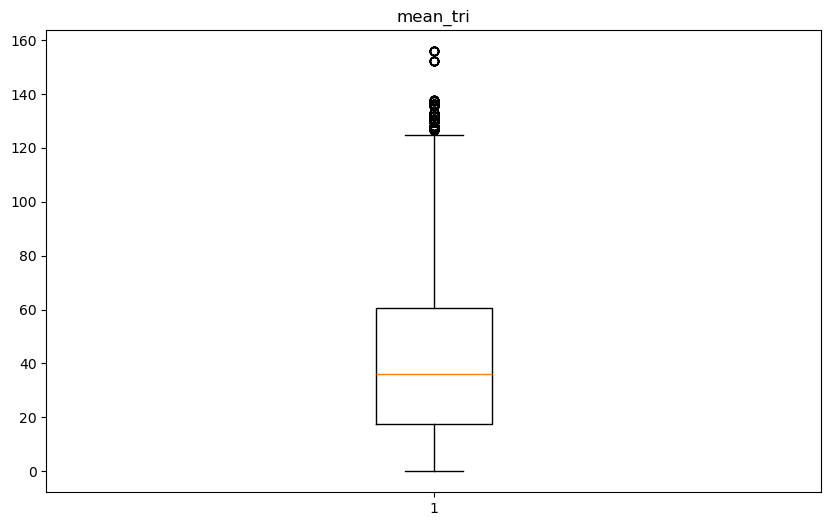

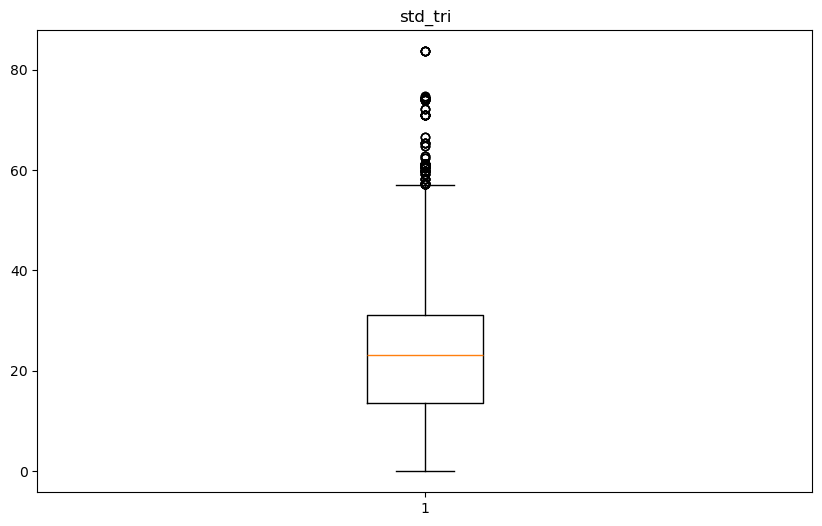

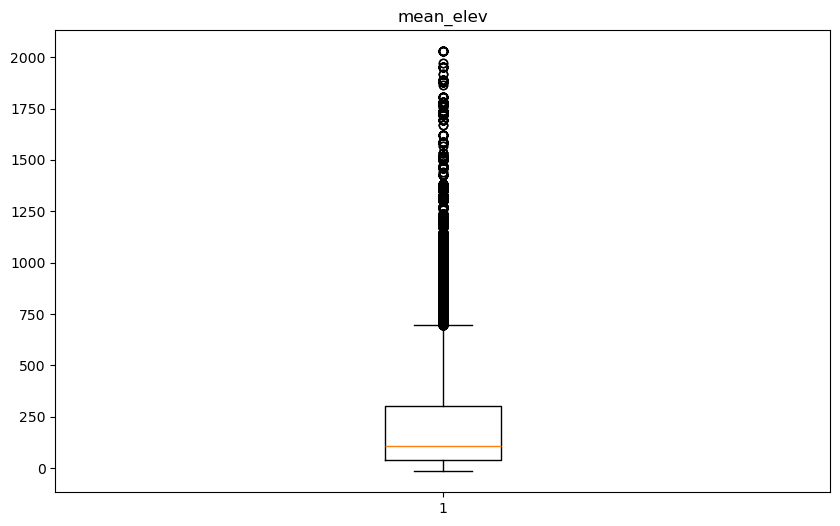

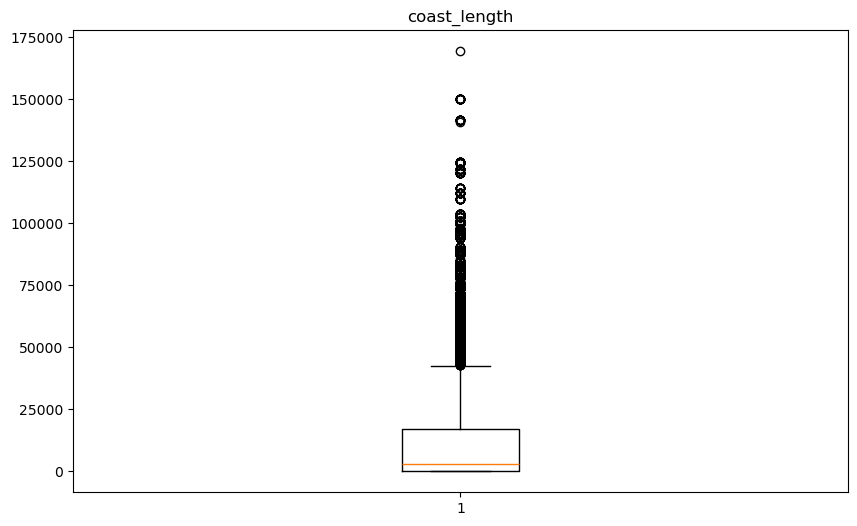

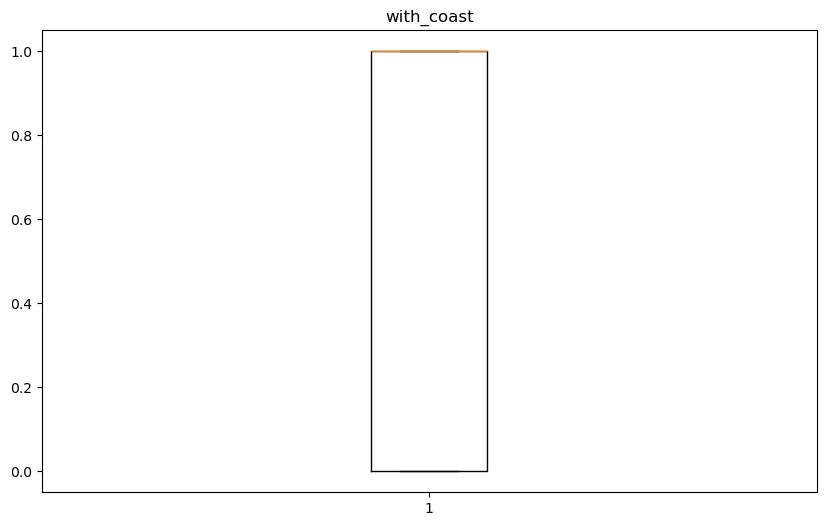

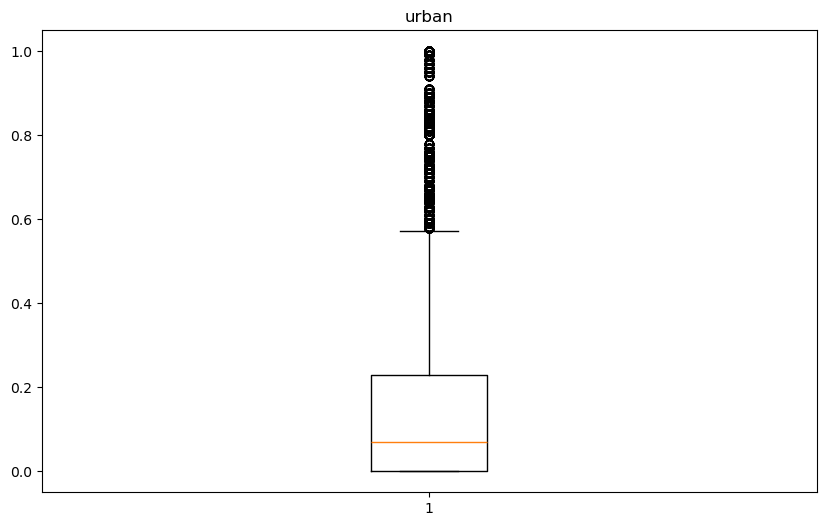

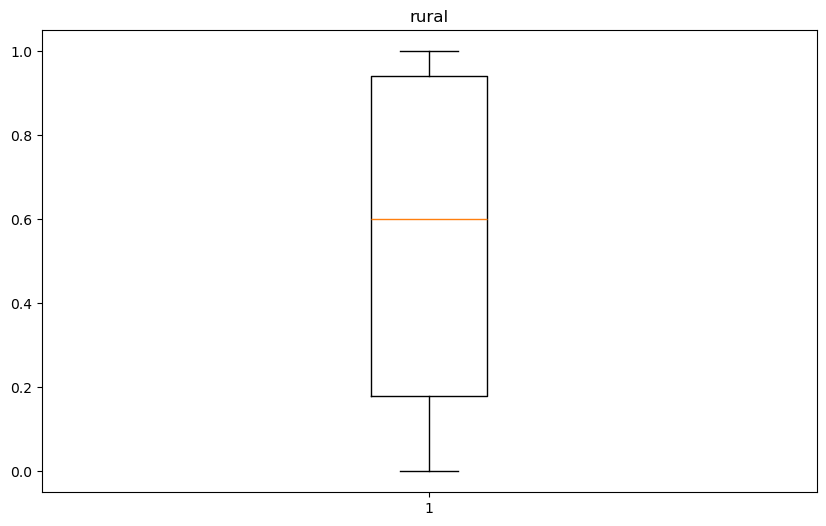

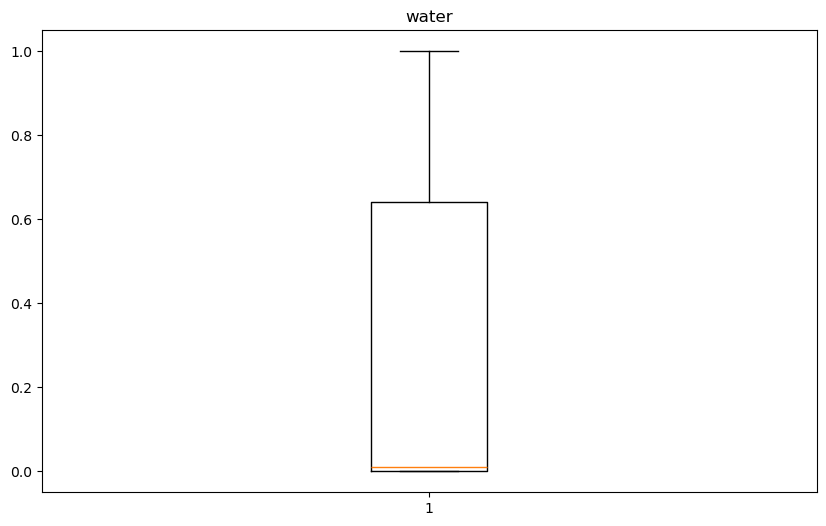

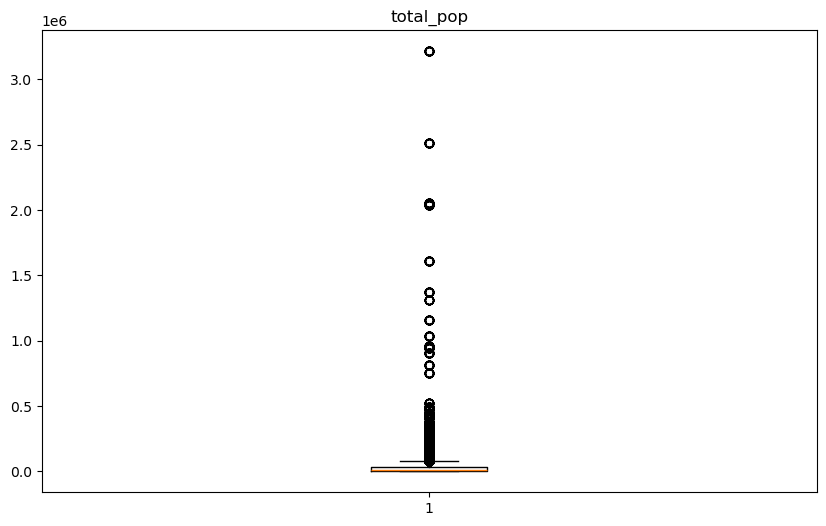

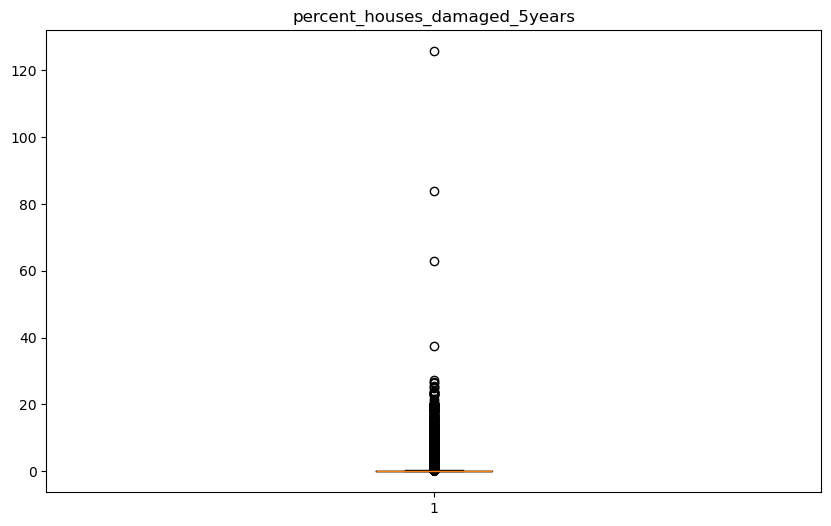

In [9]:
import matplotlib.pyplot as plt

plt.boxplot(df, features)
for feature in features:
    plt.figure(figsize=(10, 6))
    plt.title(feature)
    plt.boxplot(df[feature])
    plt.show()

In [4]:
import lime
import lime.lime_tabular

explainer = lime.lime_tabular.LimeTabularExplainer(training_data=X_train, feature_names=features, verbose=True, mode='regression', discretize_continuous=False)


In [37]:
np.std(X_train)
np.mean(X_train[8])

-0.10251473349948344

## LIME for one instance

In [5]:
instance = X_test[0]
print(X_test[0])
explanation = explainer.explain_instance(instance, xgb_model.predict, num_features=len(features))
explanation.show_in_notebook(show_table = True, show_all = False)
explanation.as_list()

[-0.55396531  0.82459305 -0.10819771 -0.56364661 -0.17846537 -0.00861924
  0.31451644  1.83673062  0.37838282  2.19169017  0.18770967 -0.65721469
 -1.06928384 -0.08015816  0.81976967 -0.77726058 -0.1250148   1.34907533]
Intercept 0.4378621082231332
Prediction_local [-0.07657642]
Right: -0.030170586


[('wind_speed', 0.4503418202459384),
 ('track_distance', -0.1832818129607309),
 ('rwi', -0.13142809620405718),
 ('rainfall_max_24h', 0.08410811208170418),
 ('std_slope', -0.05749588751554095),
 ('rainfall_max_6h', 0.05722834781470464),
 ('coast_length', 0.050347687217639985),
 ('percent_houses_damaged_5years', 0.043815462644867784),
 ('urban', -0.03396759895622014),
 ('total_houses', -0.030764883349784642),
 ('mean_slope', -0.025116988498036327),
 ('mean_elev', -0.024176090617673833),
 ('water', 0.02040911465751152),
 ('with_coast', -0.013367421102782915),
 ('total_pop', -0.012654259293963065),
 ('std_tri', 0.011192155126188378),
 ('rural', -0.00980015367418686),
 ('mean_tri', 0.005058884495668047)]

In [6]:
exp_df = pd.DataFrame(explanation.as_list(),columns=['Feature','Contribution'])
# sort by absolute contribution
exp_df.sort_values(by='Contribution', key=abs, ascending=False, inplace=True)
exp_df



Feature  Contribution
0                      wind_speed      0.450342
1                  track_distance     -0.183282
2                             rwi     -0.131428
3                rainfall_max_24h      0.084108
4                       std_slope     -0.057496
5                 rainfall_max_6h      0.057228
6                    coast_length      0.050348
7   percent_houses_damaged_5years      0.043815
8                           urban     -0.033968
9                    total_houses     -0.030765
10                     mean_slope     -0.025117
11                      mean_elev     -0.024176
12                          water      0.020409
13                     with_coast     -0.013367
14                      total_pop     -0.012654
15                        std_tri      0.011192
16                          rural     -0.009800
17                       mean_tri      0.005059

In [7]:
pd.DataFrame(explanation.as_list())
print(explanation.score)

0.1242954184568773


## Global LIME

In [23]:
# Global lime values

explainer = lime.lime_tabular.LimeTabularExplainer(training_data=X_train, feature_names=features, verbose=True, mode='regression', discretize_continuous=False)

# iterate through all instances of test set and save explanations for each feature in list
lime_dict = {}

for i in range(len(X_test)):
    instance = X_test[i]
    explanation = explainer.explain_instance(instance, xgb_model.predict, num_features=len(features))
    explist = dict(explanation.as_list())
    for feature in explist.keys():
        if feature not in lime_dict:
            lime_dict[feature] = []
        lime_dict[feature].append(explist[feature])

print(lime_dict)

avg_lime_dict = {}
for key in lime_dict.keys():
    avg_lime_dict[key] = np.mean(np.abs(lime_dict[key]))

avg_lime_dict

Intercept 0.395027692950264
Prediction_local [0.03783424]
Right: -0.030170586
Intercept 0.44674543552521706
Prediction_local [1.79530503]
Right: 0.5290078
Intercept 0.4313462917860246
Prediction_local [0.43593667]
Right: 0.13395418
Intercept 0.4197622081652146
Prediction_local [0.50706912]
Right: 0.04915137
Intercept 0.4108029307365229
Prediction_local [0.57401844]
Right: 0.07312768
Intercept 0.4274062095273555
Prediction_local [1.86424669]
Right: 0.49015546
Intercept 0.44484224353201934
Prediction_local [0.63171132]
Right: 0.8183421
Intercept 0.4143464826363745
Prediction_local [1.83596949]
Right: 1.774486
Intercept 0.42126371734168766
Prediction_local [2.15108175]
Right: 2.781075
Intercept 0.4178362624515744
Prediction_local [1.0155962]
Right: 0.108476795
Intercept 0.40770188988527944
Prediction_local [1.7930085]
Right: 1.303105
Intercept 0.40531169402849393
Prediction_local [0.04961018]
Right: 0.013427935
Intercept 0.4170769744963383
Prediction_local [0.28832866]
Right: 0.039501354


{'wind_speed': 0.5206500328912301,
 'track_distance': 0.2196618248499812,
 'rainfall_max_6h': 0.08437110232850802,
 'percent_houses_damaged_5years': 0.06782036418215327,
 'rwi': 0.11875492690265628,
 'rainfall_max_24h': 0.05174917506366473,
 'urban': 0.04077552262609966,
 'coast_length': 0.02939519761365569,
 'std_slope': 0.01599075389359749,
 'total_houses': 0.015478714270176726,
 'water': 0.01509527533202051,
 'mean_elev': 0.02577039049421649,
 'rural': 0.015587325685605207,
 'mean_tri': 0.014186646759746584,
 'mean_slope': 0.014723233550584832,
 'with_coast': 0.01424368122056517,
 'total_pop': 0.02397987571905346,
 'std_tri': 0.014527777845233535}

In [25]:
pd.DataFrame(lime_dict)

wind_speed  track_distance  rainfall_max_6h  \
0       0.381254       -0.179635         0.089448   
1       0.751858       -0.248441         0.130925   
2       0.517554       -0.227474         0.097545   
3       0.531691       -0.217981         0.087403   
4       0.464830       -0.223728         0.102690   
...          ...             ...              ...   
9946    0.492652       -0.157337         0.045941   
9947    0.355976       -0.195611         0.072024   
9948    0.572842       -0.287266         0.067716   
9949    0.756219       -0.237249         0.041617   
9950    0.440549       -0.206926         0.061113   

      percent_houses_damaged_5years       rwi  rainfall_max_24h     urban  \
0                          0.081972 -0.054304          0.046065 -0.029244   
1                          0.100803 -0.126064          0.078011 -0.021278   
2                          0.088221 -0.131682          0.056569  0.000181   
3                          0.050672 -0.126379          0.053537 -0.048913   
4                          0.046380 -0.077232          0.037330 -0.007442   
...                             ...       ...               ...       ...   
9946                       0.052292 -0.091396          0.063112 -0.024912   
9947                       0.054563 -0.091505          0.057198 -0.030290   
9948                       0.074735 -0.080366          0.060171 -0.054777   
9949                       0.079549 -0.143618          0.062980 -0.057484   
9950                       0.064046 -0.142729          0.061657 -0.051436   

      coast_length  std_slope  total_houses     water  mean_elev     rural  \
0         0.021264  -0.017980      0.013844  0.007604  -0.006733  0.005159   
1        -0.006382  -0.091511      0.013738  0.030698  -0.045304  0.004790   
2         0.035380  -0.044539     -0.015750  0.038686  -0.052776  0.002703   
3         0.033903  -0.002382     -0.027050 -0.018277  -0.037150 -0.027631   
4         0.023916  -0.021615     -0.001328  0.005231  -0.012636  0.002022   
...            ...        ...           ...       ...        ...       ...   
9946      0.022307  -0.025174     -0.001202  0.001653  -0.029684 -0.008785   
9947      0.024827   0.009394     -0.013599  0.008158  -0.019442  0.016881   
9948     -0.013534   0.004423     -0.007986  0.017830  -0.031485  0.034241   
9949      0.039841  -0.025803      0.034916  0.011320  -0.027478 -0.035024   
9950      0.028008  -0.020178     -0.027816  0.031154  -0.030719  0.033074   

      mean_tri  mean_slope  with_coast  total_pop   std_tri  
0    -0.004488   -0.003216   -0.001996  -0.001830  0.000773  
1     0.022298   -0.026503    0.045812  -0.046171 -0.002041  
2    -0.002449   -0.001751    0.012328  -0.021878  0.012048  
3     0.015489   -0.008494    0.025119  -0.031801 -0.009681  
4    -0.009412    0.014092    0.012057  -0.004342 -0.005853  
...        ...         ...         ...        ...       ...  
9946 -0.020300   -0.004562   -0.014331  -0.013135 -0.005414  
9947  0.001391   -0.002382    0.013408  -0.010905 -0.001732  
9948 -0.009422   -0.014560   -0.006233  -0.034945 -0.025876  
9949  0.003150   -0.006802    0.018583  -0.011601 -0.017673  
9950 -0.006760   -0.008895   -0.006716  -0.050964 -0.012776  

[9951 rows x 18 columns]

In [27]:
# standard deviation for all features
std_lime_dict = {}
for key in lime_dict.keys():
    std_lime_dict[key] = np.std(lime_dict[key])
std_lime_dict

{'wind_speed': 0.12340442613065661,
 'track_distance': 0.042332416899054204,
 'rainfall_max_6h': 0.025776597072761444,
 'percent_houses_damaged_5years': 0.022516080948512273,
 'rwi': 0.04355902917613244,
 'rainfall_max_24h': 0.021665389101083298,
 'urban': 0.020182429472947336,
 'coast_length': 0.021939713730567936,
 'std_slope': 0.019617019209243247,
 'total_houses': 0.018391453236975074,
 'water': 0.01966696542091475,
 'mean_elev': 0.019024642479272175,
 'rural': 0.01988188792181193,
 'mean_tri': 0.01863511464876329,
 'mean_slope': 0.018640119137495324,
 'with_coast': 0.01878217436641607,
 'total_pop': 0.01880645283305045,
 'std_tri': 0.01944189686149204}

In [29]:
dflime = pd.DataFrame(avg_lime_dict, index=["Value"]).transpose().sort_values(by="Value", ascending=False)
#
dflime["sd"] = pd.DataFrame(std_lime_dict, index=["Value"]).transpose()
dflime

Value        sd
wind_speed                     0.520650  0.123404
track_distance                 0.219662  0.042332
rwi                            0.118755  0.043559
rainfall_max_6h                0.084371  0.025777
percent_houses_damaged_5years  0.067820  0.022516
rainfall_max_24h               0.051749  0.021665
urban                          0.040776  0.020182
coast_length                   0.029395  0.021940
mean_elev                      0.025770  0.019025
total_pop                      0.023980  0.018806
std_slope                      0.015991  0.019617
rural                          0.015587  0.019882
total_houses                   0.015479  0.018391
water                          0.015095  0.019667
mean_slope                     0.014723  0.018640
std_tri                        0.014528  0.019442
with_coast                     0.014244  0.018782
mean_tri                       0.014187  0.018635

In [10]:
lime_list = pd.DataFrame(avg_lime_dict, index=["Value"]).transpose().sort_values(by="Value", ascending=False).index.tolist()
lime_list

['wind_speed',
 'track_distance',
 'rwi',
 'rainfall_max_6h',
 'percent_houses_damaged_5years',
 'rainfall_max_24h',
 'urban',
 'coast_length',
 'mean_elev',
 'total_pop',
 'rural',
 'total_houses',
 'water',
 'std_tri',
 'std_slope',
 'with_coast',
 'mean_tri',
 'mean_slope']

## SHAP

In [11]:
import shap
import pandas as pd
#from shap import markers

# background = maskers.Independent(X_train, 10) # data to train both explainers on

X_train4shapely = pd.DataFrame(data=X_train, columns=features)
explainer = shap.Explainer(xgb_model, X_train4shapely)
shap_values = explainer.shap_values(X_test)

In [12]:
shap_values.shape
X_test.shape

(9951, 18)

In [13]:
explainer_xgb = shap.TreeExplainer(xgb_model, X_train4shapely)
# shap_values_xgb = explainer_xgb(X_train4shapely)
#pred = xgb_model.predict(X_test, output_margin=True)

explainer2 = shap.TreeExplainer(xgb_model, X_train4shapely)
# explanation = explainer(X_test)

shap_values2 = explainer2(X_test)
# make sure the SHAP values add up to marginal predictions
# np.abs(shap_values.sum(axis=1) + explanation.base_values - pred).max()
shap_values2

.values =
array([[-7.25653216e-01, -1.46276993e-01, -1.24712820e-02, ...,
        -1.01196951e-02,  2.40514474e-04,  7.08663231e-02],
       [ 2.72652098e-01,  9.67665884e-02,  4.51241423e-02, ...,
        -4.27864008e-02,  1.39327080e-02, -1.99086760e-01],
       [-7.33135610e-01, -2.03956308e-01, -1.24712820e-02, ...,
        -5.67691270e-03,  3.26148713e-03,  9.23185935e-02],
       ...,
       [-3.09503078e-01,  3.44308855e-01, -2.37400903e-02, ...,
         1.46461565e-02,  7.29650606e-03, -2.54316806e-01],
       [ 2.88314808e+00, -1.44828711e-02, -3.90116570e-02, ...,
        -1.01196951e-02, -8.26495776e-02,  2.65874607e-01],
       [-6.12697707e-01, -9.79617385e-02,  1.69365181e-02, ...,
         3.61422879e-03,  7.84370390e-03, -8.23804158e-02]])

.base_values =
array([1.02127119, 1.02127119, 1.02127119, ..., 1.02127119, 1.02127119,
       1.02127119])

.data =
array([[-0.55396531,  0.82459305, -0.10819771, ..., -0.77726058,
        -0.1250148 ,  1.34907533],
       [ 1.93999

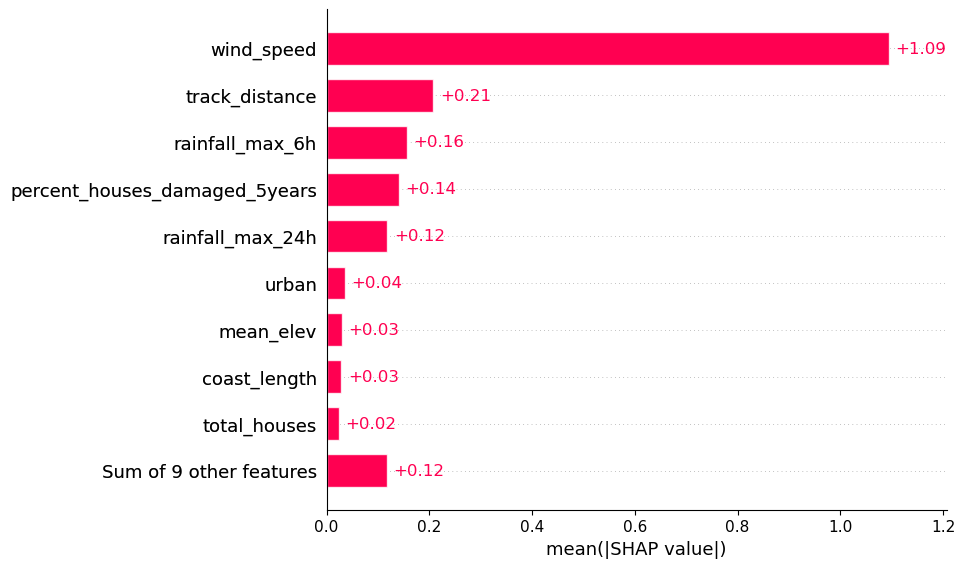

In [14]:
shap.plots.bar(shap_values2)

In [15]:
pd.DataFrame(shap_values2.values, columns=shap_values2.feature_names)

wind_speed  track_distance  total_houses  rainfall_max_6h  \
0      -0.725653       -0.146277     -0.012471        -0.152840   
1       0.272652        0.096767      0.045124        -0.139432   
2      -0.733136       -0.203956     -0.012471        -0.057981   
3      -0.608869       -0.119442      0.001792        -0.108421   
4      -0.588096        0.056411     -0.019374        -0.110501   
...          ...             ...           ...              ...   
9946   -0.671429       -0.172134     -0.012919        -0.067774   
9947   -0.599028       -0.101760     -0.019374        -0.110901   
9948   -0.309503        0.344309     -0.023740        -0.130824   
9949    2.883148       -0.014483     -0.039012        -0.145557   
9950   -0.612698       -0.097962      0.016937        -0.110270   

      rainfall_max_24h       rwi  mean_slope  std_slope  mean_tri   std_tri  \
0            -0.087936  0.003015    0.002709   0.003839  0.001568  0.075032   
1            -0.280184  0.011583   -0.077219  -0.097339 -0.070228  0.074608   
2             0.008784  0.005211    0.002709   0.009427  0.001568  0.000000   
3            -0.110512  0.004362    0.002709   0.003177  0.001568  0.000000   
4            -0.101807  0.000549    0.002709  -0.013342  0.000896  0.000000   
...                ...       ...         ...        ...       ...       ...   
9946         -0.016706  0.003864   -0.019856  -0.016321 -0.006676  0.000000   
9947         -0.095358 -0.000222    0.002709   0.001769  0.000896  0.000000   
9948          0.008806  0.014210    0.002709  -0.040358  0.000896  0.000000   
9949         -0.334293  0.018201    0.062038   0.054037  0.000896  0.000000   
9950         -0.095770  0.003680   -0.022334  -0.016321  0.001568  0.000000   

      mean_elev  coast_length  with_coast     urban     rural     water  \
0     -0.030463     -0.016201    0.000854 -0.026387 -0.001216 -0.010120   
1     -0.110912     -0.042088    0.000854  0.034238  0.017251 -0.042786   
2      0.007138      0.001001    0.000000 -0.004299 -0.001216 -0.005677   
3     -0.003655      0.004133    0.000000  0.026654 -0.001216  0.011198   
4     -0.010322     -0.008369   -0.000384 -0.067626 -0.001954 -0.008699   
...         ...           ...         ...       ...       ...       ...   
9946  -0.016415     -0.020900   -0.000384 -0.006672 -0.001216 -0.007651   
9947  -0.010420      0.001601    0.000000 -0.033613 -0.001954 -0.006725   
9948   0.020315      0.015343    0.000000 -0.026781 -0.001216  0.014646   
9949   0.004343     -0.019757    0.000000 -0.032178 -0.002691 -0.010120   
9950  -0.005399      0.004133    0.000000  0.024804 -0.001216  0.003614   

      total_pop  percent_houses_damaged_5years  
0      0.000241                       0.070866  
1      0.013933                      -0.199087  
2      0.003261                       0.092319  
3      0.009349                      -0.084947  
4      0.009798                      -0.088033  
...         ...                            ...  
9946   0.002188                       0.092082  
9947   0.000241                      -0.083161  
9948   0.007297                      -0.254317  
9949  -0.082650                       0.265875  
9950   0.007844                      -0.082380  

[9951 rows x 18 columns]

In [16]:
# average SHAP values for each feature
shap_avg = shap_values2.abs.mean(axis=0).values
pd.DataFrame(shap_avg.reshape(1, -1), columns=shap_values2.feature_names).transpose().sort_values(by=0, ascending=False)

0
wind_speed                     1.094608
track_distance                 0.207404
rainfall_max_6h                0.155926
percent_houses_damaged_5years  0.140943
rainfall_max_24h               0.118454
urban                          0.035135
mean_elev                      0.029477
coast_length                   0.028439
total_houses                   0.023208
rwi                            0.021398
std_slope                      0.021070
mean_slope                     0.020770
total_pop                      0.014121
mean_tri                       0.013761
water                          0.012643
rural                          0.005753
std_tri                        0.005581
with_coast                     0.002027

In [17]:
shap_list = pd.DataFrame(shap_avg.reshape(1, -1), columns=shap_values2.feature_names).transpose().sort_values(by=0, ascending=False)[0].keys()
shap_list

Index(['wind_speed', 'track_distance', 'rainfall_max_6h',
       'percent_houses_damaged_5years', 'rainfall_max_24h', 'urban',
       'mean_elev', 'coast_length', 'total_houses', 'rwi', 'std_slope',
       'mean_slope', 'total_pop', 'mean_tri', 'water', 'rural', 'std_tri',
       'with_coast'],
      dtype='object')

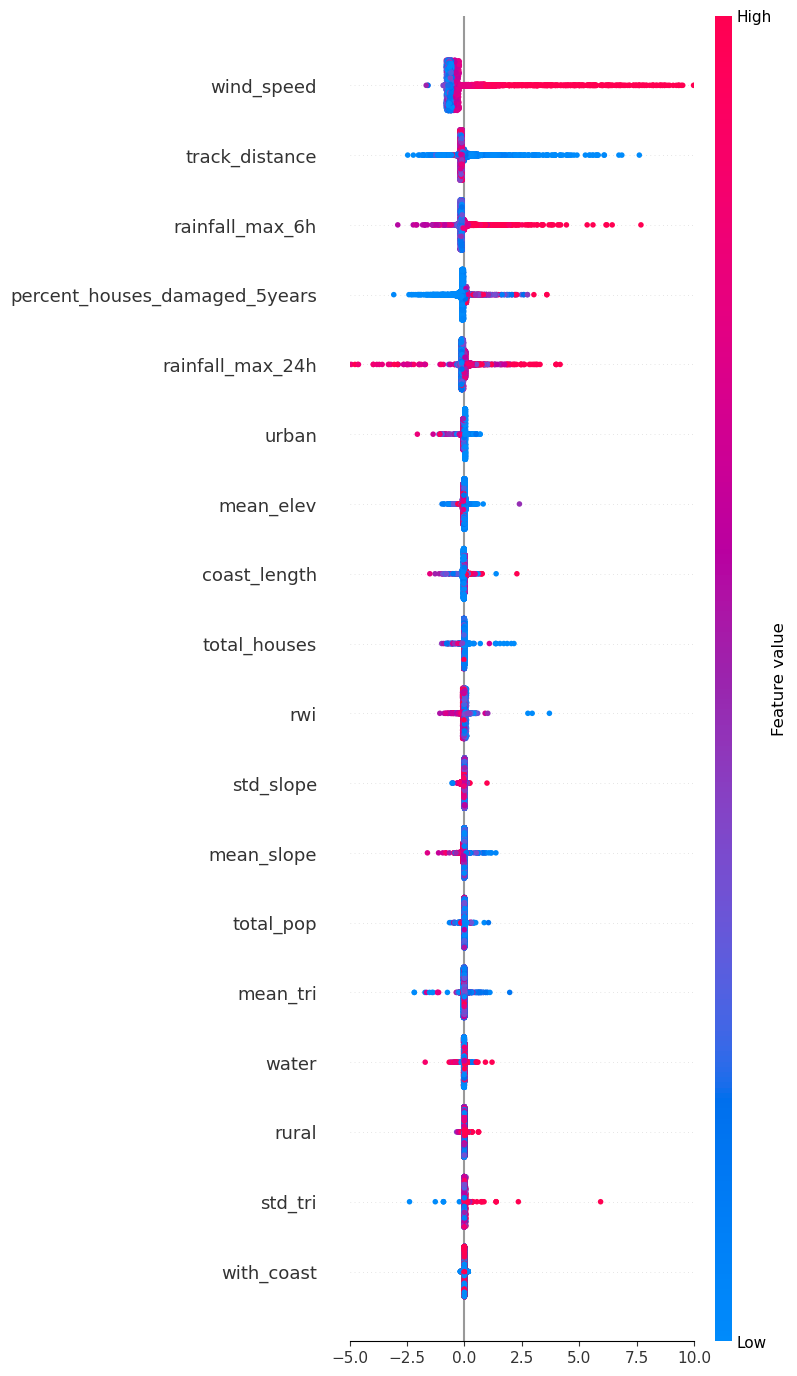

In [18]:
shap.summary_plot(shap_values2, max_display=30, plot_size=0.7, show=False)
ax = plt.gca()

ax.set_xlabel("")
# You can change the min and max value of xaxis by changing the arguments of:
ax.set_xlim(-5, 10)
plt.show()

In [19]:
xgb_model.feature_importances_
# to pd-dataframe
xgb_df = pd.DataFrame(xgb_model.feature_importances_, index=features, columns=["Importance"]).sort_values(by="Importance", ascending=False)

xgb_df

Importance
wind_speed                       0.275721
std_tri                          0.075317
track_distance                   0.066827
with_coast                       0.058273
rainfall_max_24h                 0.056690
mean_tri                         0.045909
percent_houses_damaged_5years    0.044407
rainfall_max_6h                  0.042017
mean_slope                       0.041864
std_slope                        0.040832
total_pop                        0.039616
mean_elev                        0.035277
water                            0.035204
total_houses                     0.034621
rural                            0.034247
rwi                              0.031051
coast_length                     0.027962
urban                            0.014165

In [20]:
# xgb_df to list of indices
xgb_list = xgb_df.index.tolist()
xgb_list

['wind_speed',
 'std_tri',
 'track_distance',
 'with_coast',
 'rainfall_max_24h',
 'mean_tri',
 'percent_houses_damaged_5years',
 'rainfall_max_6h',
 'mean_slope',
 'std_slope',
 'total_pop',
 'mean_elev',
 'water',
 'total_houses',
 'rural',
 'rwi',
 'coast_length',
 'urban']